<a href="https://colab.research.google.com/github/diwadu/dw_matrix_road_sign/blob/master/dw_matrix_3_d_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np 
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score

# %load_ext tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure

In [0]:
cd '/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign


In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [0]:
  y_train.shape, y_test.shape

((34799,), (4410,))

In [0]:
#dodajemy wymiar (robimy macierz dla tensorflowa)
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [0]:
y_train.shape, y_test.shape

((34799, 43), (4410, 43))

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [0]:
model = Sequential([

  Conv2D(filters=65, kernel_size=(3,3), activation='relu', 
         input_shape=input_shape),
  Flatten(),
  Dense(num_classes, activation='softmax')
])

#model.summary()
#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
#model.fit(X_train, y_train)

In [0]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']
#labels_dict

In [0]:
def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(
      X_train, 
      y_train,
      batch_size=params_fit.get('batch_size', 128),
      epochs=params_fit.get('epochs', 5),
      verbose= True,
      validation_data = params_fit.get('validation_data', (X_train, y_train)),
      callbacks = [tensorboard_callback]
      )
  
  return model

def predict(model_trained, X_test, y_test, scoring = accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)
  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)
  return scoring(y_test_norm, y_pred)

def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  predict(model_trained, X_test, y_test)

def get_cnn_v1(input_shape, num_classes):
  return Sequential([
      Conv2D(filters=65, kernel_size=(3,3), activation='relu', 
         input_shape=input_shape),
      Flatten(),
      Dense(num_classes, activation='softmax')
  ])

def get_cnn_v2(input_shape, num_classes):
  return Sequential([
      Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
      MaxPool2D(),
      Dropout(0.5),

      Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),
      
      Flatten(),

      Dense(1024, activation='relu'),
      Dropout(0.5),

      Dense(num_classes, activation='softmax')
  ])

def get_cnn_v3(input_shape, num_classes):
    return Sequential([
      Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
      Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),

      Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),
      
      Flatten(),

      Dense(1024, activation='relu'),
      Dropout(0.3),

      Dense(num_classes, activation='softmax')
  ])
    
def get_cnn_v4(input_shape, num_classes):
    return Sequential([
      Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
      Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
      MaxPool2D(),
      Dropout(0.3),

      Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
      Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),

      #jak damy za dużo warstw to bedzie zmienijszał rozmiar(?) zdjęcia w summary
      Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'), 
      Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),
      
      Flatten(),

      Dense(1024, activation='relu'),
      Dropout(0.3),

      Dense(num_classes, activation='softmax')
  ])
    
#get_cnn_v4(input_shape, num_classes).summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 64)         

In [0]:
train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 8.5080 - accuracy: 0.1097 - val_loss: 2.9566 - val_accuracy: 0.1975
Epoch 2/5
272/272 [==============================] - 4s 14ms/step - loss: 2.5244 - accuracy: 0.3065 - val_loss: 1.7383 - val_accuracy: 0.4985
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 1.7202 - accuracy: 0.4787 - val_loss: 1.0924 - val_accuracy: 0.6963
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 1.1600 - accuracy: 0.6402 - val_loss: 0.5421 - val_accuracy: 0.8633
Epoch 5/5
272/272 [==============================] - 4s 14ms/step - loss: 0.7923 - accuracy: 0.7527 - val_loss: 0.2923 - val_accuracy: 0.9232


In [0]:
train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 5s 19ms/step - loss: 2.9621 - accuracy: 0.4550 - val_loss: 0.4633 - val_accuracy: 0.8805
Epoch 2/5
272/272 [==============================] - 5s 19ms/step - loss: 0.5924 - accuracy: 0.8258 - val_loss: 0.1893 - val_accuracy: 0.9535
Epoch 3/5
272/272 [==============================] - 5s 19ms/step - loss: 0.3221 - accuracy: 0.9045 - val_loss: 0.0772 - val_accuracy: 0.9798
Epoch 4/5
272/272 [==============================] - 5s 19ms/step - loss: 0.2084 - accuracy: 0.9385 - val_loss: 0.0394 - val_accuracy: 0.9895
Epoch 5/5
272/272 [==============================] - 5s 19ms/step - loss: 0.1582 - accuracy: 0.9528 - val_loss: 0.0348 - val_accuracy: 0.9909


In [0]:
train_and_predict(get_cnn_v4(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 6s 23ms/step - loss: 2.4348 - accuracy: 0.3252 - val_loss: 1.0653 - val_accuracy: 0.6565
Epoch 2/5
272/272 [==============================] - 6s 22ms/step - loss: 0.8674 - accuracy: 0.7226 - val_loss: 0.2194 - val_accuracy: 0.9342
Epoch 3/5
272/272 [==============================] - 6s 22ms/step - loss: 0.3723 - accuracy: 0.8826 - val_loss: 0.1009 - val_accuracy: 0.9672
Epoch 4/5
272/272 [==============================] - 6s 22ms/step - loss: 0.2314 - accuracy: 0.9279 - val_loss: 0.0458 - val_accuracy: 0.9863
Epoch 5/5
272/272 [==============================] - 6s 21ms/step - loss: 0.1730 - accuracy: 0.9489 - val_loss: 0.0241 - val_accuracy: 0.9931


In [0]:
def get_cnn_v5(input_shape, num_classes):
    return Sequential([
      Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
      Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
      MaxPool2D(),
      Dropout(0.3),

      Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
      Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),

      #jak damy za dużo warstw to bedzie zmienijszał rozmiar(?) zdjęcia w summary
      Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'), 
      Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),
      
      Flatten(),

      Dense(1024, activation='relu'),
      Dropout(0.3),

      Dense(1024, activation='relu'),
      Dropout(0.3),
      
      Dense(num_classes, activation='softmax')
  ])

In [0]:
train_and_predict(get_cnn_v5(input_shape, num_classes))
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 6s 24ms/step - loss: 2.8630 - accuracy: 0.2385 - val_loss: 1.2690 - val_accuracy: 0.5626
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 1.0479 - accuracy: 0.6654 - val_loss: 0.3601 - val_accuracy: 0.8955
Epoch 3/5
272/272 [==============================] - 6s 22ms/step - loss: 0.5113 - accuracy: 0.8394 - val_loss: 0.1401 - val_accuracy: 0.9563
Epoch 4/5
272/272 [==============================] - 6s 22ms/step - loss: 0.3246 - accuracy: 0.9005 - val_loss: 0.0917 - val_accuracy: 0.9712
Epoch 5/5
272/272 [==============================] - 6s 22ms/step - loss: 0.2375 - accuracy: 0.9281 - val_loss: 0.0568 - val_accuracy: 0.9834


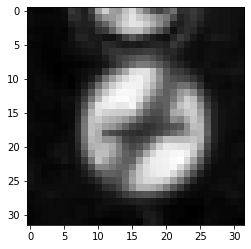

In [0]:
#konwersja kanałów rgb do szarości (redukcja kanałów)
plt.imshow(color.rgb2gray(X_train[0]), cmap=plt.get_cmap('gray'))

In [0]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

In [0]:
model = get_cnn_v4((32, 32, 1), num_classes)
model_trained = train_model(model, X_train_gray, y_train, params_fit={})
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 6s 22ms/step - loss: 2.6767 - accuracy: 0.2641 - val_loss: 0.6943 - val_accuracy: 0.7928
Epoch 2/5
272/272 [==============================] - 6s 21ms/step - loss: 0.5189 - accuracy: 0.8355 - val_loss: 0.1445 - val_accuracy: 0.9552
Epoch 3/5
272/272 [==============================] - 6s 21ms/step - loss: 0.2361 - accuracy: 0.9236 - val_loss: 0.0617 - val_accuracy: 0.9826
Epoch 4/5
272/272 [==============================] - 6s 21ms/step - loss: 0.1529 - accuracy: 0.9520 - val_loss: 0.0377 - val_accuracy: 0.9892
Epoch 5/5
272/272 [==============================] - 6s 21ms/step - loss: 0.1195 - accuracy: 0.9626 - val_loss: 0.0239 - val_accuracy: 0.9936


0.9650793650793651

In [0]:
#dalszy preprocessing
def preproc_img(img):
  hsv = color.rgb2hsv(img)
  hsv[:,:,2] = exposure.equalize_adapthist(hsv[:,:,2])
  img = color.hsv2rgb(hsv)
  return img

In [0]:
def recognize_sign(img_nr):
  y_test_norm = np.argmax(y_test, axis=1)
  y_pred_prob = model_trained.predict(X_test_gray)
  y_pred = np.argmax(y_pred_prob, axis=1)
  print(labels_dict[np.argmax(y_pred_prob[IMG_NR])])
  print(X_train_gray.shape, X_train.shape)
  plt.imshow(color.rgb2gray(X_test[IMG_NR]), cmap=plt.get_cmap('gray'))
  plt.show()
  plt.bar(range(43), y_pred_prob[IMG_NR])
  plt.show()

Road work
(34799, 32, 32, 1) (34799, 32, 32, 3)


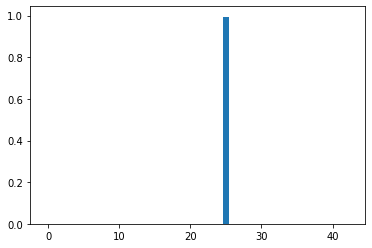

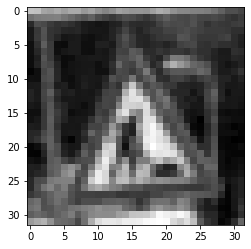

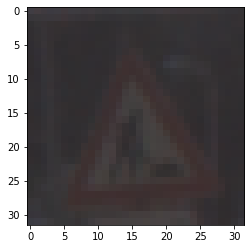

In [0]:
IMG_NR =  4400 #1100 #400
recognize_sign(IMG_NR)